In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
import numpy as np
import seaborn as sns

from bs4 import BeautifulSoup   # conda install -c anaconda beautifulsoup4 
import requests

from pymeteo import radar    #conda install -c cwebster2 pymeteo

%load_ext autoreload
%autoreload 2

In [2]:
### Create dask cluster to work parallel in large datasets

from dask.distributed import Client
client = Client(n_workers=2, 
                threads_per_worker=2, 
                memory_limit='2GB',
                processes=False)
client
chunks={'time' : 10,}
client 

Client Scheduler: inproc://10.0.0.51/354342/1 Dashboard: http://10.0.0.51:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [3]:
# plot cosmetics
sns.set_context('paper', font_scale = 1.6)

sns.set(font = 'Serif', font_scale = 1.6, )
sns.set_style('ticks', 
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--',
                   'axes.grid': True,
                  }, 
                   )

In [4]:
#thredds = 'https://thredds.met.no/thredds/dodsC/remotesensingceilometer/2021/03/17/andoya/raw/20210317_Andoya_CHM190135'#_2125_000.nc'

In [5]:
year = 2021; month = '03'; day = 17

In [6]:
url = 'https://thredds.met.no/thredds/catalog/remotesensingceilometer/{}/{}/{}/andoya/raw/catalog.html'.format(year,month,day)
ext = 'nc'

def listFD(url, ext=''):
    page = requests.get(url).text
#    print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

_ff = []
for file in listFD(url, ext):
    _ff.append(file)

In [7]:
ff = []
for i in range(len(_ff)):
   # print(_ff[i][-83:])
    ff.append('https://thredds.met.no/thredds/dodsC/{}'.format(_ff[i][-83:]))
ff = sorted(ff)

In [8]:
fn = xr.Dataset( coords = {'time': np.empty(shape = 0)})

In [9]:
for i in range(len(ff)):
    fn = xr.merge([fn, xr.open_dataset('{}'.format(ff[i]), decode_times=True)])

In [10]:
bsc = fn.beta_raw

In [11]:
cbh = fn.cbh.isel(layer = 0).where(fn.cbh.isel(layer = 0) > -1.)

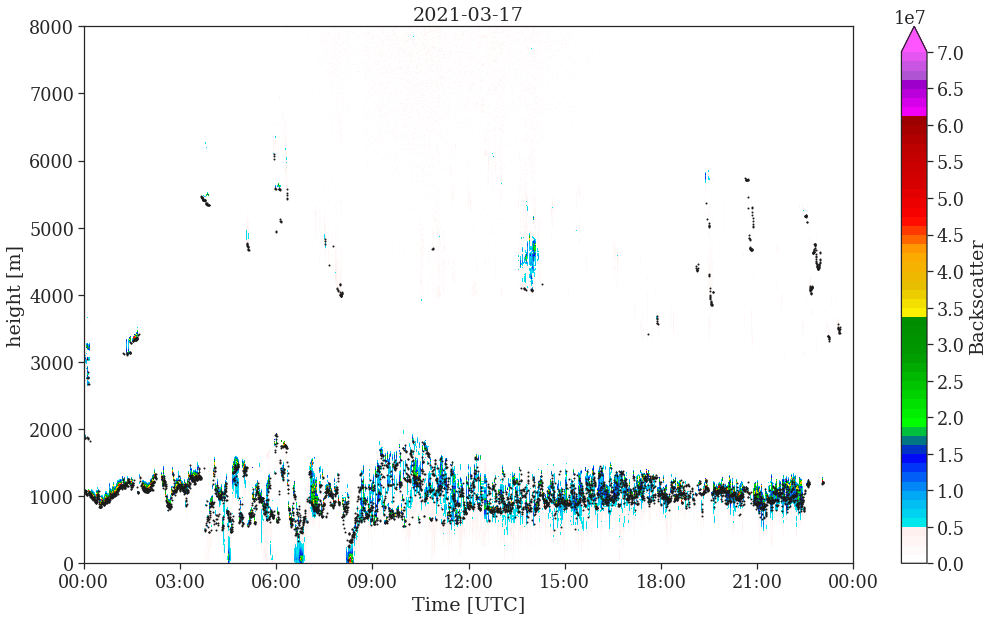

In [12]:
fig, axsm = plt.subplots(1,1, 
                         figsize=[15,9],)
#axs = axsm#.flatten()

# ceilometer backscatter   
levels = np.arange(0, 7.125e7, .125e7)
_bsc = bsc.plot.pcolormesh(ax = axsm, x = 'time', 
                    vmin =0.,  #vmax =6e7,
                    levels=levels,
                    cmap = plt.get_cmap('pymeteo_radar'), 
                    extend = 'max',
                           
                           cbar_kwargs={'ticks': levels[::4],
                                 'spacing': 'proportional',
                                 'label': 'Backscatter'},
                          )

fig.subplots_adjust(right=0.8)


#cloud base 
cbh.plot(ax = axsm, x = 'time', linestyle="",marker=".", color = 'k', markersize=2, add_legend=True, label='Cloud Base', )


axsm.set_ylim([0, 8000])
axsm.set_xlim([datetime.date(int(year), int(month), int(day)), datetime.date(int(year), int(month), int(day+1))])
# Set title and labels for axes
axsm.set(xlabel="Time [UTC]",
       ylabel="height [m]",
       title="{}-{}-{}".format(year, month, day),)
axsm.xaxis.grid()

# Define the date format
date_form = DateFormatter("%H:00")
axsm.xaxis.set_major_formatter(date_form)

plt.tight_layout();